In [59]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')





In [60]:
batch_size = 32
img_size = 64
epochs = 10
num_classes = 29  # 26 letters + [space, delete, nothing] if present

# 1. Data transforms
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalizing to [-1, 1]
])

# 2. Load dataset
dataset = datasets.ImageFolder(root=r'C:\Users\jhana\Downloads\archive(4)\asl_alphabet_train\asl_alphabet_train', transform=transform)
train_size = int(0.8 * len(dataset))
test_size=len(dataset)-train_size
train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=batch_size,  num_workers=4,
    pin_memory=True,shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers=4,
    pin_memory=True,shuffle=False)
#Preprocessing done

In [61]:
# 3. Define CNN model
class ASLCNN(nn.Module):
    def __init__(self):
        super( ASLCNN,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (B, 3, 64, 64) -> (B, 32, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # -> (B, 32, 32, 32)

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # -> (B, 64, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # -> (B, 64, 16, 16)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # -> (B, 128, 8, 8)

            nn.Flatten(),                               # -> (B, 128*8*8)
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [68]:
model = ASLCNN().to(device)


# 4. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("Training loss for every epoch:")

# 5. Training loop


Training loss for every epoch:


In [19]:
for epoch in range(epochs):  
    model.train()  
    running_loss = 0.0  

    for images, labels in train_loader:  
        images, labels = images.to(device), labels.to(device)  
        optimizer.zero_grad()

        outputs = model(images)  
        loss = criterion(outputs, labels)  

        loss.backward()  
        optimizer.step()  

        running_loss += loss 

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")  


Epoch [1/10], Loss: 0.8306
Epoch [2/10], Loss: 0.1798
Epoch [3/10], Loss: 0.1098
Epoch [4/10], Loss: 0.0848
Epoch [5/10], Loss: 0.0614
Epoch [6/10], Loss: 0.0547
Epoch [7/10], Loss: 0.0481
Epoch [8/10], Loss: 0.0443
Epoch [9/10], Loss: 0.0376
Epoch [10/10], Loss: 0.0347


In [66]:
#Testing model
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
from sklearn.metrics import confusion_matrix
import numpy as np


conf_mat = confusion_matrix(all_labels, all_preds)
accuracy = np.trace(conf_mat) / np.sum(conf_mat) * 100
print("Confusion Matrix:\n", conf_mat)


Confusion Matrix:
 [[  0 504 109   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0 504  76   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0 545  89   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0 536  85   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0 502  97   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0 568  28   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0 496  97   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0 541  31   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0 560  39

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

prec = precision_score(all_labels, all_preds, average='macro')  
rec = recall_score(all_labels, all_preds, average='macro')  
f1 = f1_score(all_labels, all_preds, average='macro')

In [65]:
print("Performance of the model:")
print(f"Test Accuracy: {accuracy:.2f}%")
print(f'Precision:{prec:.4f}')
print(f'Recall:{rec:.4f}')
print(f'F1-score:{f1:.4f}')

Performance of the model:
Test Accuracy: 99.91%
Precision:0.9991
Recall:0.9991
F1-score:0.9991


In [40]:
from PIL import Image
image_path = r'C:\Users\jhana\Downloads\archive(4)\asl_alphabet_test\asl_alphabet_test\J_test.jpg'



In [64]:
#Testing on a file
print("Sample testing")
img = Image.open(image_path)
img = transform(img)
img = img.unsqueeze(0) 
img = img.to(device)  
model.eval()
with torch.no_grad():
    output = model(img)
    _, pred = torch.max(output, 1)  
    predicted_class = dataset.classes[pred.item()]  

print(f"Predicted Class: {predicted_class}")
    



Sample testing
Predicted Class: B


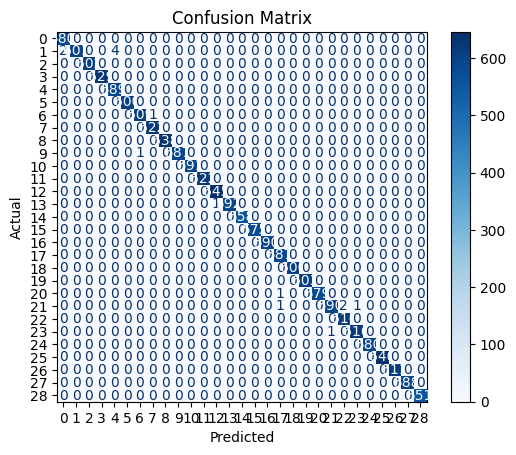

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# After collecting all_labels and all_preds lists/tensors
cm = confusion_matrix(all_labels, all_preds, normalize=None)  # or 'true' to normalize per row

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' for integer format
plt.xticks()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
